# Import library

In [1]:
import torch
from torchvision import datasets, transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, copy
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn đến tập train và test
train_path = '.\\Combined Dataset\\train'
test_path = '.\\Combined Dataset\\test'

train_dataset = datasets.ImageFolder(train_path)
test_dataset = datasets.ImageFolder(test_path)

# Kiểm tra kích thước của dataset
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 10240
Test dataset size: 1279


# Show some images from dataset

Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


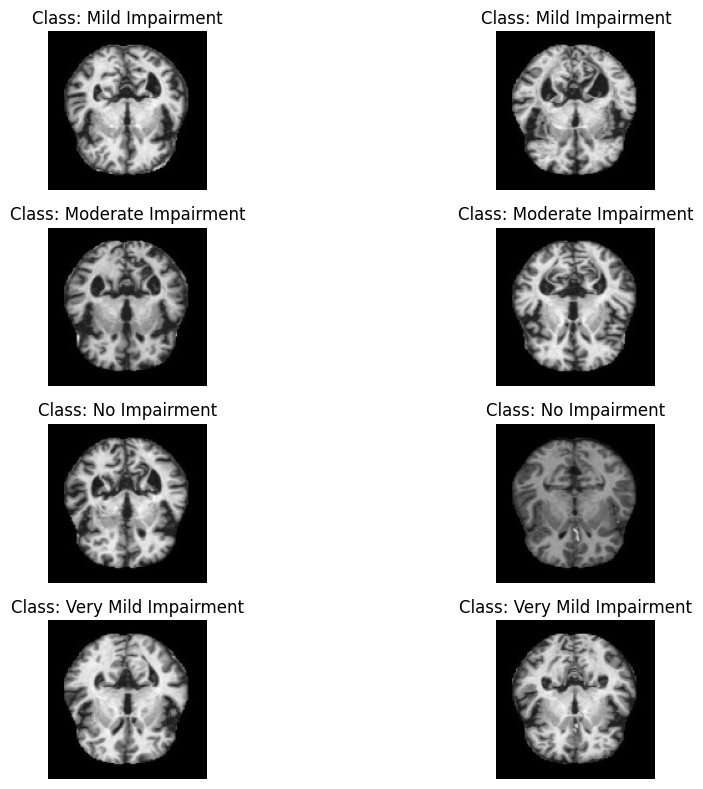

In [2]:
# List of classes in ImageFolder
labels = train_dataset.classes
print("Classes:", labels)

# Dictionary to store images for each class
images_by_class = {label: [] for label in range(len(labels))}

# Iterate over the dataset to find 2 images per class
for image, label in train_dataset:
    if len(images_by_class[label]) < 2:  # Collect up to 2 images per class
        images_by_class[label].append(image)
    if all(len(images) == 2 for images in images_by_class.values()):  # Stop when all classes have 2 images
        break

# Plot images from all classes
plt.figure(figsize=(12, 8))
for class_idx, (label, images) in enumerate(images_by_class.items()):
    for img_idx, image in enumerate(images):
        plt.subplot(len(labels), 2, class_idx * 2 + img_idx + 1)
        plt.imshow(image)
        plt.title(f"Class: {labels[label]}")
        plt.axis("off")
plt.tight_layout()
plt.show()

# Data preproccesing and loading

In [3]:
# Batch size
bs = 64
# Number of epochs
num_epochs = 30
# Number of classes
num_classes = 4
# Number of workers (CPU threads)
num_cpu = 10
# Model saving path
PATH = "c:\\Users\HanDong\\Documents\\Study\\Spring 2025\\DAP391m\\saved_models"

# Applying transforms to the data
image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}
 
# Load data from folders
dataset = {
    'train': datasets.ImageFolder(root=train_path, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=test_path, transform=image_transforms['valid'])
}
 
# Size of train and validation data
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid'])
}

# Create iterators for data loading
dataloaders = {
    'train':data.DataLoader(dataset['train'], batch_size=bs, shuffle=True,
                            num_workers=num_cpu, pin_memory=True, drop_last=True),
    'valid':data.DataLoader(dataset['valid'], batch_size=bs, shuffle=True,
                            num_workers=num_cpu, pin_memory=True, drop_last=True)
}

# Class names or target labels
class_names = dataset['train'].classes
print("Classes:", class_names)
 
# Print the train and validation data sizes
print("Training-set size:",dataset_sizes['train'],
      "\nValidation-set size:", dataset_sizes['valid'])

Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
Training-set size: 10240 
Validation-set size: 1279


# Training
Each model is trained separatedly. Before training a new model, define new 'device' and new 'model' to avoid errors.

In [5]:
# Model training routine
def train_model(model, device, num_epochs=30):

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer 
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Learning rate decay
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    since = time.time()
    train_accuracy = []
    train_losses = []
    val_accuracy = []
    val_losses = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize storage for predictions and labels
    all_preds = []
    all_labels = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Store predictions and labels in the validation phase
                if (phase == 'valid') and (epoch == num_epochs - 1) :
                    all_preds.append(preds.cpu().numpy())
                    all_labels.append(labels.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


            # Record training loss and accuracy for each phase
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracy.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracy.append(epoch_acc.item())

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Concatenate all batches' predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accuracy, train_losses, val_accuracy, val_losses, all_preds, all_labels

## ResNet50 

In [ ]:
import torchvision
from torchinfo import summary

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a custom model 
print("Loading ResNet50 for training from scratch ...\n")
model = torchvision.models.resnet50(weights= None)
model.eval()

# Transfer the model to GPU
model_ft = model.to(device)

# Print model summary
print('Model Summary:\n')
for num, (name, param) in enumerate(model_ft.named_parameters()):
    print(num, name, param.requires_grad )
summary(model_ft, input_size=(1, 3, 224, 224))
print(model_ft)

In [ ]:
# Train the model
print("Training:\n")
model_ft, train_accuracy, train_losses, val_accuracy, val_losses, val_preds, val_labels = train_model(model_ft, device, num_epochs)

torch.cuda.empty_cache()

# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, PATH + 'ResNet50_model.pth')

### Visualization

In [ ]:
# Result visualization
import matplotlib.pyplot as plt
print("ResNet50 model:")
plt.figure(figsize=(15,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(val_labels, val_preds))

## ResNet152

In [ ]:
import torchvision
from torchinfo import summary

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a custom model 
print("Loading ResNet152 for training from scratch ...\n")
model = torchvision.models.resnet152(weights= None)
model.eval()

# Transfer the model to GPU
model_ft = model.to(device)

# Print model summary
print('Model Summary:\n')
for num, (name, param) in enumerate(model_ft.named_parameters()):
    print(num, name, param.requires_grad )
summary(model_ft, input_size=(1, 3, 224, 224))
print(model_ft)

In [ ]:
# Train the model
print("Training:\n")
model_ft, train_accuracy, train_losses, val_accuracy, val_losses, val_preds, val_labels = train_model(model_ft, device, num_epochs)

torch.cuda.empty_cache()

# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, PATH + 'ResNet152_model.pth')

### Visualization

In [ ]:
# Result visualization
import matplotlib.pyplot as plt
print("ResNet152 model:")
plt.figure(figsize=(15,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(val_labels,val_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(val_labels, val_preds))

## DenseNet121

In [ ]:
from torchinfo import summary
import torchvision

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Loading DenseNet121 for training from scratch ...\n")
model = torchvision.models.densenet201(weights= None)
model.eval()

# Transfer the model to GPU
model_ft = model.to(device)

# Print model summary
print('Model Summary:\n')
summary(model_ft, input_size=(1, 3, 224, 224))
print(model_ft)

In [ ]:
# Train the model
print("Training:\n")
model_ft, train_accuracy, train_losses, val_accuracy, val_losses, val_preds, val_labels = train_model(model_ft, device, num_epochs)

torch.cuda.empty_cache()

# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, PATH + "\\DenseNet121_model.pth")

### Visualization

In [ ]:
# Result visualization
import matplotlib.pyplot as plt
print("Densenet121 model:")
plt.figure(figsize=(15,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(val_labels,val_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(val_labels, val_preds))

## DenseNet201

In [ ]:
from torchinfo import summary
import torchvision

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Loading DenseNet201 for training from scratch ...\n")
model = torchvision.models.densenet201(weights= None)
model.eval()

# Transfer the model to GPU
model_ft = model.to(device)

# Print model summary
print('Model Summary:\n')
summary(model_ft, input_size=(1, 3, 224, 224))
print(model_ft)

In [ ]:
# Train the model
print("Training:\n")
model_ft, train_accuracy, train_losses, val_accuracy, val_losses, val_preds, val_labels = train_model(model_ft, device, num_epochs)

torch.cuda.empty_cache()

# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, PATH + "\\DenseNet201_model.pth")

### Visualization

In [ ]:
# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(val_labels,val_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(val_labels, val_preds))

## MobileNetV2

In [4]:
from torchinfo import summary

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Loading MobileNetV2 for training from scratch ...\n")
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
model.eval()

# Transfer the model to GPU
model_ft = model.to(device)

# Print model summary
print('Model Summary:\n')
summary(model_ft, input_size=(1, 3, 224, 224))
print(model_ft)

Loading MobileNetV2 for training from scratch ...

Model Summary:



Using cache found in C:\Users\HanDong/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [6]:
# Train the model
print("Training:\n")
model_ft, train_accuracy, train_losses, val_accuracy, val_losses, val_preds, val_labels = train_model(model_ft, device, num_epochs)

torch.cuda.empty_cache()

# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, PATH + "\\MobileNetV2_model.pth")

Training:

Epoch 0/29
----------
train Loss: 1.7714 Acc: 0.3134
valid Loss: 9.3223 Acc: 0.0086

Epoch 1/29
----------
train Loss: 0.8602 Acc: 0.5743
valid Loss: 0.8665 Acc: 0.5278

Epoch 2/29
----------
train Loss: 0.6839 Acc: 0.6905
valid Loss: 0.8887 Acc: 0.5082

Epoch 3/29
----------
train Loss: 0.5816 Acc: 0.7373
valid Loss: 1.1514 Acc: 0.4238

Epoch 4/29
----------
train Loss: 0.4865 Acc: 0.7777
valid Loss: 1.7828 Acc: 0.3581

Epoch 5/29
----------
train Loss: 0.4214 Acc: 0.8111
valid Loss: 0.8926 Acc: 0.5082

Epoch 6/29
----------
train Loss: 0.3564 Acc: 0.8474
valid Loss: 2.4068 Acc: 0.2291

Epoch 7/29
----------
train Loss: 0.2646 Acc: 0.8980
valid Loss: 0.6593 Acc: 0.6403

Epoch 8/29
----------
train Loss: 0.2075 Acc: 0.9288
valid Loss: 0.5501 Acc: 0.6959

Epoch 9/29
----------
train Loss: 0.1731 Acc: 0.9478
valid Loss: 0.5144 Acc: 0.7076

Epoch 10/29
----------
train Loss: 0.1521 Acc: 0.9570
valid Loss: 0.5779 Acc: 0.6865

Epoch 11/29
----------
train Loss: 0.1266 Acc: 0.9704

### Evaluation

MobileNetv2 model:


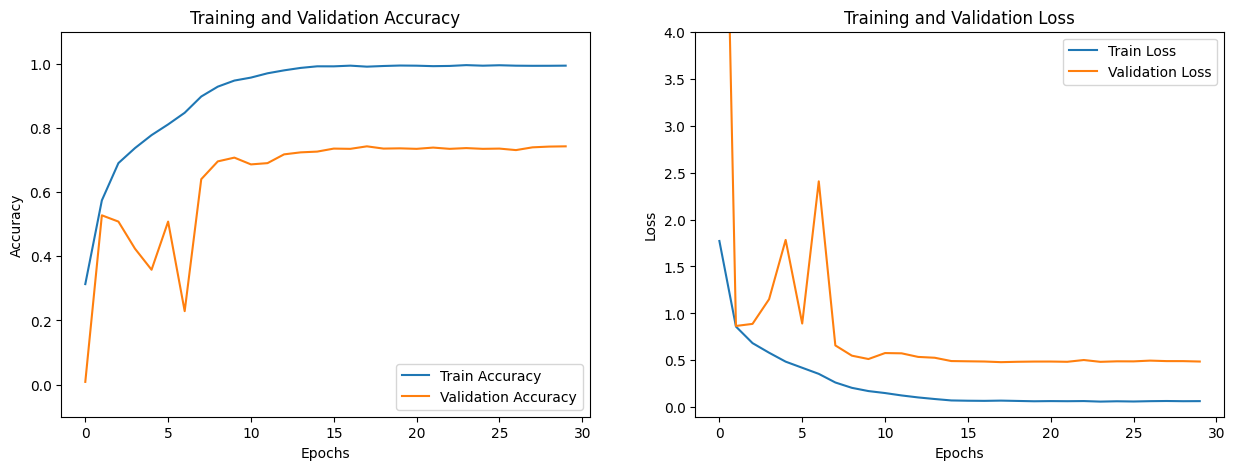

In [26]:
# Result visualization
import matplotlib.pyplot as plt
print("MobileNetv2 model:")
plt.figure(figsize=(15,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(-0.1, 4)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

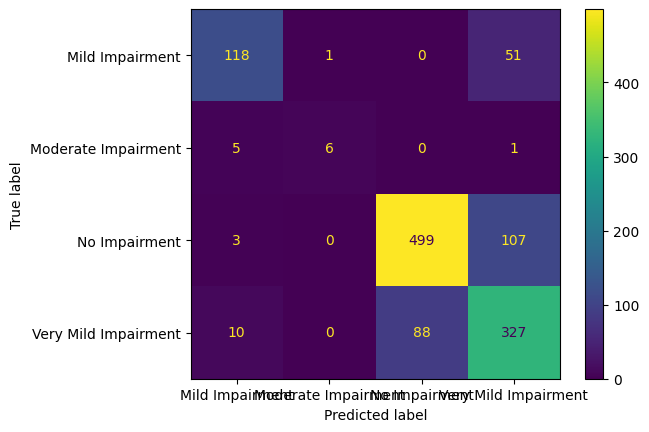

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(val_labels,val_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])
cm_display.plot()
plt.show()

In [9]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77       170
           1       0.86      0.50      0.63        12
           2       0.85      0.82      0.83       609
           3       0.67      0.77      0.72       425

    accuracy                           0.78      1216
   macro avg       0.81      0.70      0.74      1216
weighted avg       0.79      0.78      0.78      1216



## MobileNetV3_small

In [4]:
from torchinfo import summary
import torchvision

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Loading MobileNetV3_small for training from scratch ...\n")
model = torchvision.models.mobilenet_v3_small(weights= None)
model.eval()

# Transfer the model to GPU
model_ft = model.to(device)

# Print model summary
print('Model Summary:\n')
summary(model_ft, input_size=(1, 3, 224, 224))
print(model_ft)

Loading MobileNetV3_small for training from scratch ...

Model Summary:

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2):

In [6]:
# Train the model
print("Training:\n")
model_ft, train_accuracy, train_losses, val_accuracy, val_losses, val_preds, val_labels = train_model(model_ft, device, num_epochs)
torch.cuda.empty_cache()

# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, PATH + "\\MobileNetV3_small.pth")

Training:

Epoch 0/29
----------
train Loss: 6.4647 Acc: 0.2991
valid Loss: 6.1533 Acc: 0.4722

Epoch 1/29
----------
train Loss: 3.2800 Acc: 0.2932
valid Loss: 4.6067 Acc: 0.4824

Epoch 2/29
----------
train Loss: 0.9751 Acc: 0.4986
valid Loss: 1.4659 Acc: 0.4785

Epoch 3/29
----------
train Loss: 0.8348 Acc: 0.5710
valid Loss: 1.4689 Acc: 0.1314

Epoch 4/29
----------
train Loss: 0.6885 Acc: 0.6834
valid Loss: 1.2124 Acc: 0.4292

Epoch 5/29
----------
train Loss: 0.4941 Acc: 0.7835
valid Loss: 4.5875 Acc: 0.4824

Epoch 6/29
----------
train Loss: 0.3639 Acc: 0.8554
valid Loss: 1.4387 Acc: 0.4980

Epoch 7/29
----------
train Loss: 0.2657 Acc: 0.9232
valid Loss: 0.6088 Acc: 0.6513

Epoch 8/29
----------
train Loss: 0.2309 Acc: 0.9442
valid Loss: 0.4790 Acc: 0.7475

Epoch 9/29
----------
train Loss: 0.2125 Acc: 0.9536
valid Loss: 0.6573 Acc: 0.6403

Epoch 10/29
----------
train Loss: 0.1984 Acc: 0.9583
valid Loss: 0.5130 Acc: 0.7248

Epoch 11/29
----------
train Loss: 0.1850 Acc: 0.9656

### Evaluation

Densenet161 model:


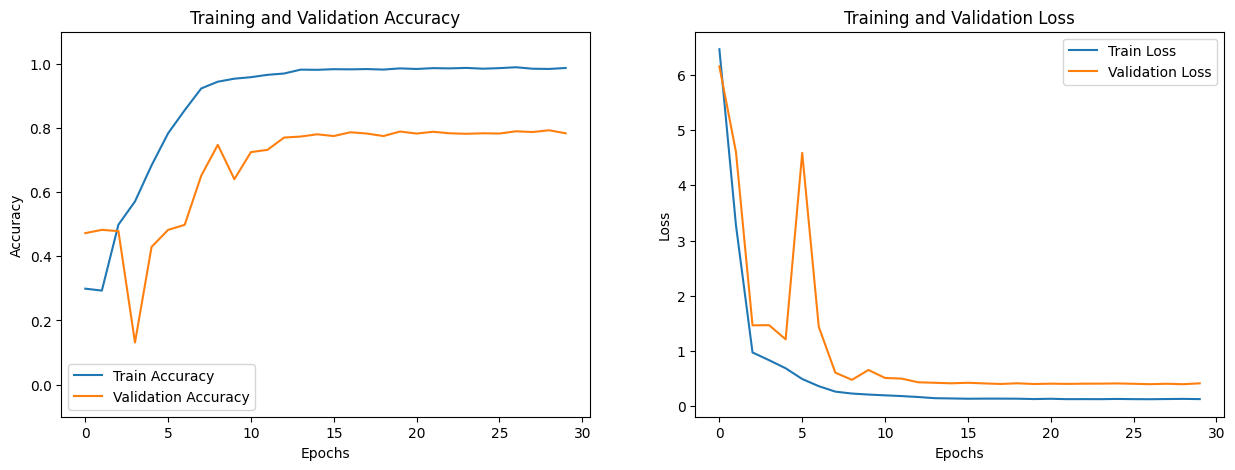

In [8]:
# Result visualization
import matplotlib.pyplot as plt
print("MobileNetV3_small model:")
plt.figure(figsize=(15,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

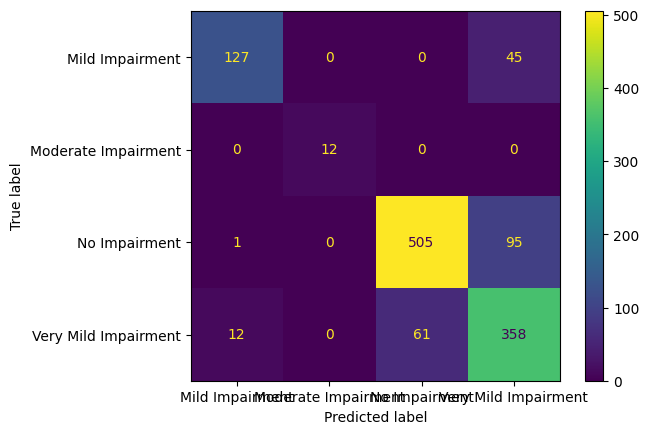

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(val_labels,val_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])
cm_display.plot()
plt.show()

In [10]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.91      0.74      0.81       172
           1       1.00      1.00      1.00        12
           2       0.89      0.84      0.87       601
           3       0.72      0.83      0.77       431

    accuracy                           0.82      1216
   macro avg       0.88      0.85      0.86      1216
weighted avg       0.83      0.82      0.83      1216



## MobileNetV3_large

In [4]:
import torchvision
from torchinfo import summary

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Loading MobileNetV3_large for training from scratch ...\n")
model = torchvision.models.mobilenet_v3_large(weights= None)
model.eval()

# Transfer the model to GPU
model_ft = model.to(device)

# Print model summary
print('Model Summary:\n')
summary(model_ft, input_size=(1, 3, 224, 224))
print(model_ft)

Loading MobileNetV3_large for training from scratch ...

Model Summary:

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActiva

In [6]:
# Train the model
print("Training:\n")
model_ft, train_accuracy, train_losses, val_accuracy, val_losses, val_preds, val_labels = train_model(model_ft, device, num_epochs)

torch.cuda.empty_cache()

# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, PATH + '\\MobileNetV3_large.pth')

Training:

Epoch 0/29
----------
train Loss: 5.9474 Acc: 0.3216
valid Loss: 6.1157 Acc: 0.4754

Epoch 1/29
----------
train Loss: 1.8528 Acc: 0.4264
valid Loss: 3.9495 Acc: 0.4785

Epoch 2/29
----------
train Loss: 0.7832 Acc: 0.6395
valid Loss: 1.3919 Acc: 0.4730

Epoch 3/29
----------
train Loss: 0.5751 Acc: 0.7431
valid Loss: 1.6144 Acc: 0.4746

Epoch 4/29
----------
train Loss: 0.4377 Acc: 0.8087
valid Loss: 1.8182 Acc: 0.3002

Epoch 5/29
----------
train Loss: 0.3533 Acc: 0.8497
valid Loss: 4.4813 Acc: 0.1783

Epoch 6/29
----------
train Loss: 0.2933 Acc: 0.8836
valid Loss: 3.5303 Acc: 0.2510

Epoch 7/29
----------
train Loss: 0.2064 Acc: 0.9334
valid Loss: 0.6090 Acc: 0.6740

Epoch 8/29
----------
train Loss: 0.1550 Acc: 0.9631
valid Loss: 0.4919 Acc: 0.7365

Epoch 9/29
----------
train Loss: 0.1337 Acc: 0.9709
valid Loss: 0.4570 Acc: 0.7545

Epoch 10/29
----------
train Loss: 0.1134 Acc: 0.9770
valid Loss: 0.4495 Acc: 0.7600

Epoch 11/29
----------
train Loss: 0.0994 Acc: 0.9839

### Evaluation

ResNet50 model:


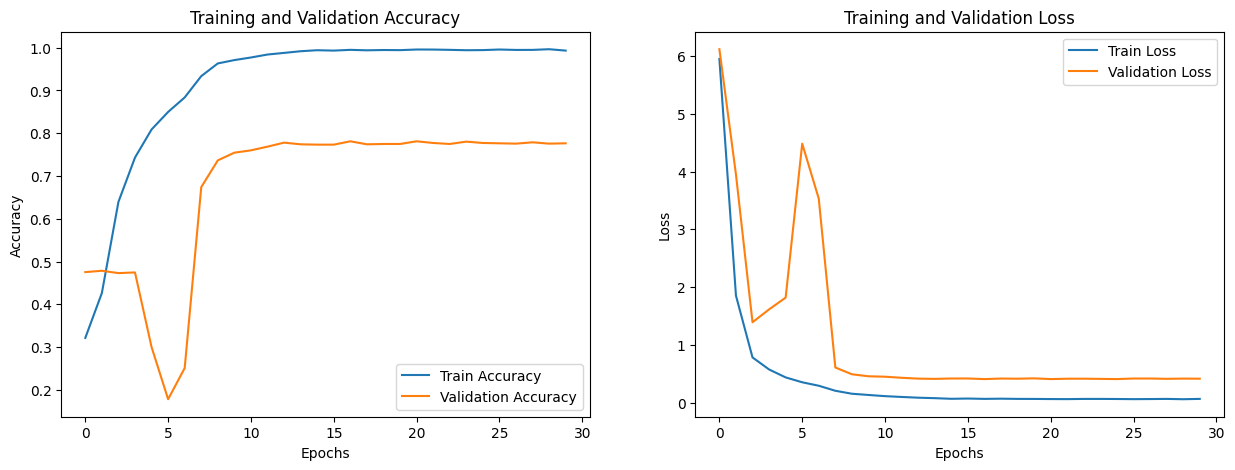

In [7]:
# Result visualization
import matplotlib.pyplot as plt
print("MobileNetV3 large:")
plt.figure(figsize=(15,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

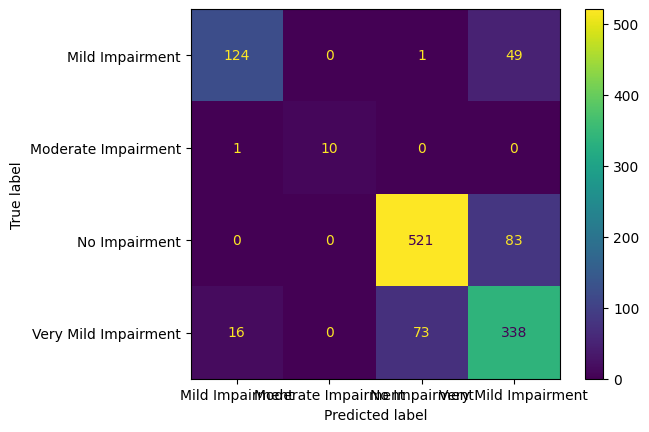

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])
cm_display.plot()
plt.show()

In [9]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.88      0.71      0.79       174
           1       1.00      0.91      0.95        11
           2       0.88      0.86      0.87       604
           3       0.72      0.79      0.75       427

    accuracy                           0.82      1216
   macro avg       0.87      0.82      0.84      1216
weighted avg       0.82      0.82      0.82      1216



## EfficienNetB0

In [10]:
from torchinfo import summary
import torchvision

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Loading EfficentNetB0 for training from scratch ...\n")
model = torchvision.models.efficientnet_b0(weights= None)
model.eval()

# Transfer the model to GPU
model_ft = model.to(device)

# Print model summary
print('Model Summary:\n')
summary(model_ft, input_size=(1, 3, 224, 224))
print(model_ft)

Loading EfficentNetB0 for training from scratch ...

Model Summary:

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scal

In [6]:
# Train the model
print("Training:\n")
model_ft, train_accuracy, train_losses, val_accuracy, val_losses, val_preds, val_labels = train_model(model_ft, device, num_epochs)

torch.cuda.empty_cache()

# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, PATH + "\\EfficienNetB0.pth")

Training:

Epoch 0/29
----------
train Loss: 2.4783 Acc: 0.4454
valid Loss: 0.8669 Acc: 0.5215

Epoch 1/29
----------
train Loss: 0.5963 Acc: 0.7501
valid Loss: 0.8346 Acc: 0.5715

Epoch 2/29
----------
train Loss: 0.4070 Acc: 0.8321
valid Loss: 0.7303 Acc: 0.6419

Epoch 3/29
----------
train Loss: 0.3013 Acc: 0.8850
valid Loss: 0.5106 Acc: 0.7623

Epoch 4/29
----------
train Loss: 0.2065 Acc: 0.9264
valid Loss: 0.4008 Acc: 0.7866

Epoch 5/29
----------
train Loss: 0.1550 Acc: 0.9433
valid Loss: 0.5089 Acc: 0.7866

Epoch 6/29
----------
train Loss: 0.1242 Acc: 0.9564
valid Loss: 0.2929 Acc: 0.8483

Epoch 7/29
----------
train Loss: 0.0860 Acc: 0.9713
valid Loss: 0.2113 Acc: 0.8827

Epoch 8/29
----------
train Loss: 0.0664 Acc: 0.9799
valid Loss: 0.2416 Acc: 0.8741

Epoch 9/29
----------
train Loss: 0.0586 Acc: 0.9823
valid Loss: 0.2042 Acc: 0.8874

Epoch 10/29
----------
train Loss: 0.0569 Acc: 0.9823
valid Loss: 0.1762 Acc: 0.8921

Epoch 11/29
----------
train Loss: 0.0523 Acc: 0.9831

### Evaluation

EfficienNetB0 model:


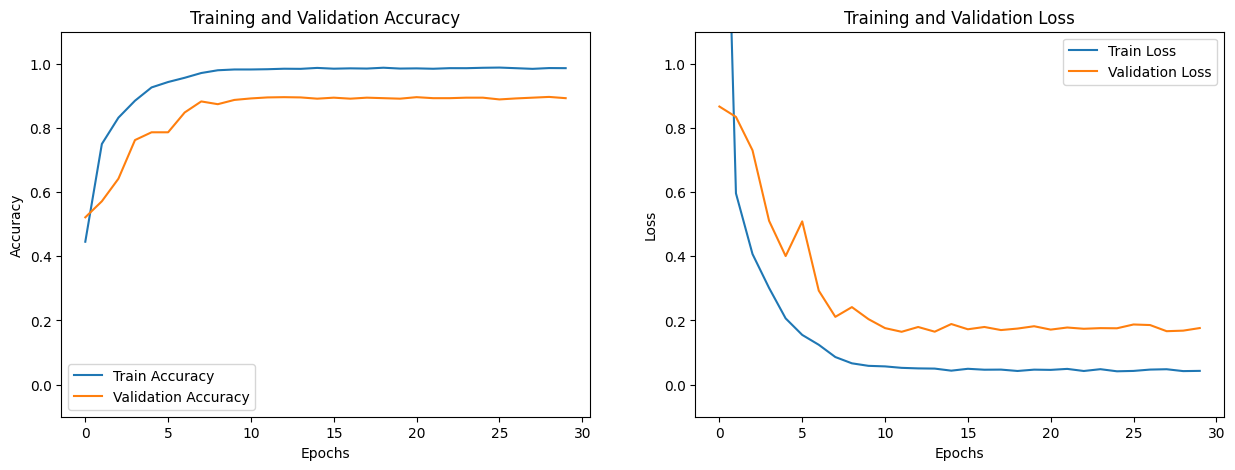

In [7]:
# Result visualization
import matplotlib.pyplot as plt
print("EfficienNetB0 model:")
plt.figure(figsize=(15,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

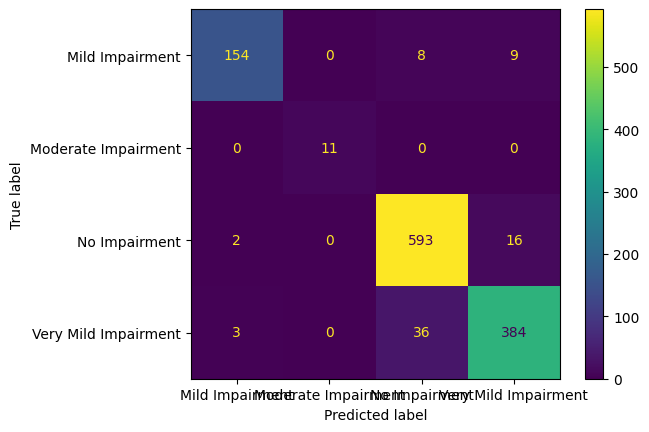

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(val_labels,val_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])
cm_display.plot()
plt.show()

In [9]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       171
           1       1.00      1.00      1.00        11
           2       0.93      0.97      0.95       611
           3       0.94      0.91      0.92       423

    accuracy                           0.94      1216
   macro avg       0.96      0.94      0.95      1216
weighted avg       0.94      0.94      0.94      1216



# GradCAM

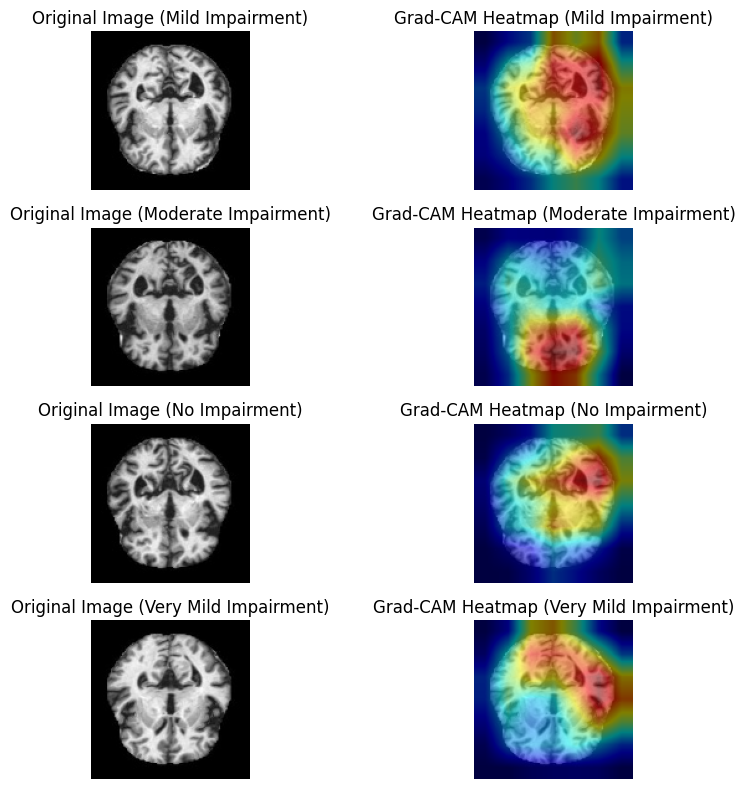

In [15]:
import torch
from torchvision import transforms
import cv2
import GradCAM
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model
model = torch.load('.\\saved_models\\MobileNetV2_pretrained.pth', map_location=device, weights_only=False) # Change the model to your model

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize (adjust to your dataset)
])

# List of classes in dataset
labels = train_dataset.classes

# Dictionary to store images for each class
images_by_class = {label: None for label in range(len(labels))}

# Iterate over the dataset to find 2 images per class
for image, label in train_dataset:
    if images_by_class[label] is None:  # If no image for this class has been found yet
        if image.mode != 'RGB':
             image = image.convert('RGB')
        images_by_class[label] = image
    if all(images_by_class.values()):  # Break when all classes have an image
        break

# Plot images from all classes
plt.figure(figsize=(10, 8))
for idx, (label, image) in enumerate(images_by_class.items()):
    # Convert PIL image to numpy
    image_np = np.array(image)

    # Simulate Grad-CAM heatmap
    gradcam_heatmap = GradCAM.compute_gradCAM(model, image, transform, device)

    # Convert the Grad-CAM mask to the original image size
    gradcam_heatmap = cv2.resize(gradcam_heatmap, (image.width, image.height))

    # Overlay the Grad-CAM heatmap on the image
    overlayed_image = GradCAM.apply_colormap_on_image(image_np, gradcam_heatmap)

    plt.subplot(len(labels), 2, idx * 2 + 1)
    plt.imshow(image_np)
    plt.title(f"Original Image ({labels[label]})")
    plt.axis("off")

    plt.subplot(len(labels), 2, idx * 2 + 2)
    plt.imshow(overlayed_image)
    plt.title(f"Grad-CAM Heatmap ({labels[label]})")
    plt.axis("off")

plt.tight_layout()
plt.show()